In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")


def load_data(file_path):
    """
    - Dosya yoluna göre .csv veya .xlsx dosyasını okur.
    - 'Date' sütunu varsa datetime'a çevirir, zaman serisi indeksi yapar.
    """
    try:
        ext = os.path.splitext(file_path)[-1].lower()
        if ext == ".csv":
            df = pd.read_csv(file_path)
        elif ext in [".xls", ".xlsx"]:
            df = pd.read_excel(file_path)
        else:
            print("Desteklenmeyen dosya uzantısı.")
            return None

        print("Dosya başarıyla yüklendi.")
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df.set_index("Date", inplace=True)
            df.sort_index(inplace=True)
            print("'Date' sütunu zaman serisi indeksine çevrildi.")
        return df

    except FileNotFoundError:
        print("Hata: Dosya bulunamadı. Lütfen dosya yolunu kontrol edin.")
    except pd.errors.ParserError:
        print("Hata: Dosya doğru biçimlendirilmemiş.")
    except Exception as e:
        print(f"Bilinmeyen bir hata oluştu: {e}")


def detect_outliers_iqr(data, column):
    """
    - IQR yöntemiyle aykırı değerleri tespit eder.
    - Ancak silme işlemi yapmaz, sadece sayısını döner.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"Aykırı değer sayısı: {outliers.shape[0]}")
    return outliers


def plot_time_series(data, column, title="Time Series Plot"):
    """
    - Zaman serisini çizmek için.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data[column], color="tab:blue", linewidth=1)
    plt.title(title, fontsize=16)
    plt.xlabel("Tarih", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_monthly_boxplot(data, column, month_col="Month", title="Monthly Boxplot"):
    """
    - Aylık boxplot: her ayın dağılımını gösterir.
    """
    plt.figure(figsize=(14, 6))
    sns.boxplot(x=month_col, y=column, data=data, palette="coolwarm")
    plt.title(title, fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_monthly_mean_trend(data, month_col="Month", value_col="Mean", title="Aylık Ortalama PM10 Trendi"):
    """
    - Aylık ortalama trend grafiği.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data[month_col], data[value_col], marker="o", linestyle="-", linewidth=2, color="darkblue")
    plt.title(title, fontsize=16)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Ortalama PM10 (µg/m³)", fontsize=12)
    plt.xticks(
        ticks=range(1, 13),
        labels=["Ocak", "Şubat", "Mart", "Nisan", "Mayıs", "Haziran", "Temmuz", "Ağustos", "Eylül", "Ekim", "Kasım", "Aralık"],
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_acf_pacf(data, column, lags=40):
    """
    - ACF ve PACF grafikleri.
    """
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plot_acf(data[column], ax=plt.gca(), lags=lags)
    plt.title("ACF (Otokorelasyon)", fontsize=14)

    plt.subplot(1, 2, 2)
    plot_pacf(data[column], ax=plt.gca(), lags=lags, method="ywm")
    plt.title("PACF (Kısmi Otokorelasyon)", fontsize=14)

    plt.tight_layout()
    plt.show()


def run_stationarity_tests(series, name="Zaman Serisi"):
    """
    - ADF ve KPSS testlerini seri üzerinde uygular.
    - Log dönüşümü sonrası seri durağan mı diye test ederiz.
    """
    print(f"=== ADF (Augmented Dickey-Fuller) Testi: {name} ===")
    adf_result = adfuller(series.dropna())
    print(f"Test İstatistiği: {adf_result[0]:.4f}")
    print(f"p-değeri: {adf_result[1]:.4f}")
    print("Kritik Değerler:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    if adf_result[1] < 0.05:
        print("→ ADF Sonucu: Seri durağandır (H0 reddedildi).")
    else:
        print("→ ADF Sonucu: Seri durağan değildir (H0 kabul edildi).")

    print("\n=== KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Testi: ===")
    kpss_result = kpss(series.dropna(), regression="c", nlags="auto")
    print(f"Test İstatistiği: {kpss_result[0]:.4f}")
    print(f"p-değeri: {kpss_result[1]:.4f}")
    print("Kritik Değerler:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")
    if kpss_result[1] < 0.05:
        print("→ KPSS Sonucu: Seri durağan değildir (H0 reddedildi).")
    else:
        print("→ KPSS Sonucu: Seri durağandır (H0 kabul edildi).")


def evaluate_model(name, model, X_test, y_test):
    """
    - OLS ve Huber için test seti üzerinde RMSE / MAE hesaplar.
    """
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Dosya başarıyla yüklendi.
'Date' sütunu zaman serisi indeksine çevrildi.
Mean        0
Mean_log    0
dtype: int64
Aykırı değer sayısı: 105


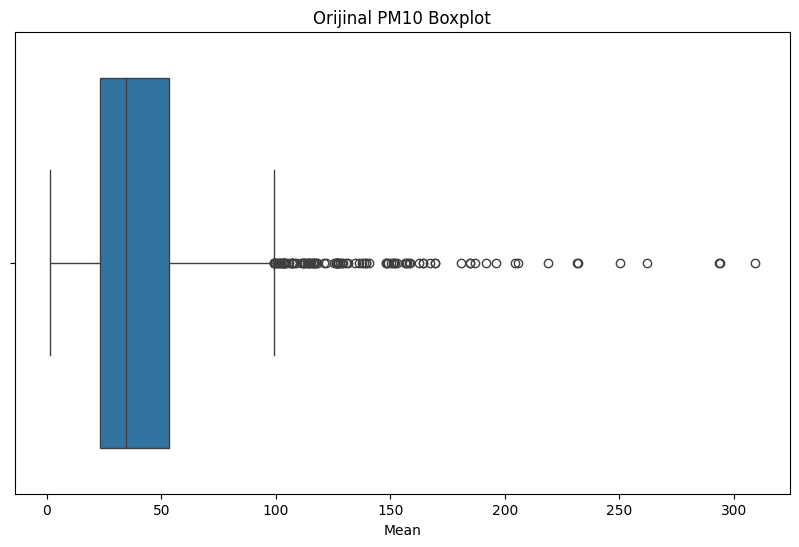

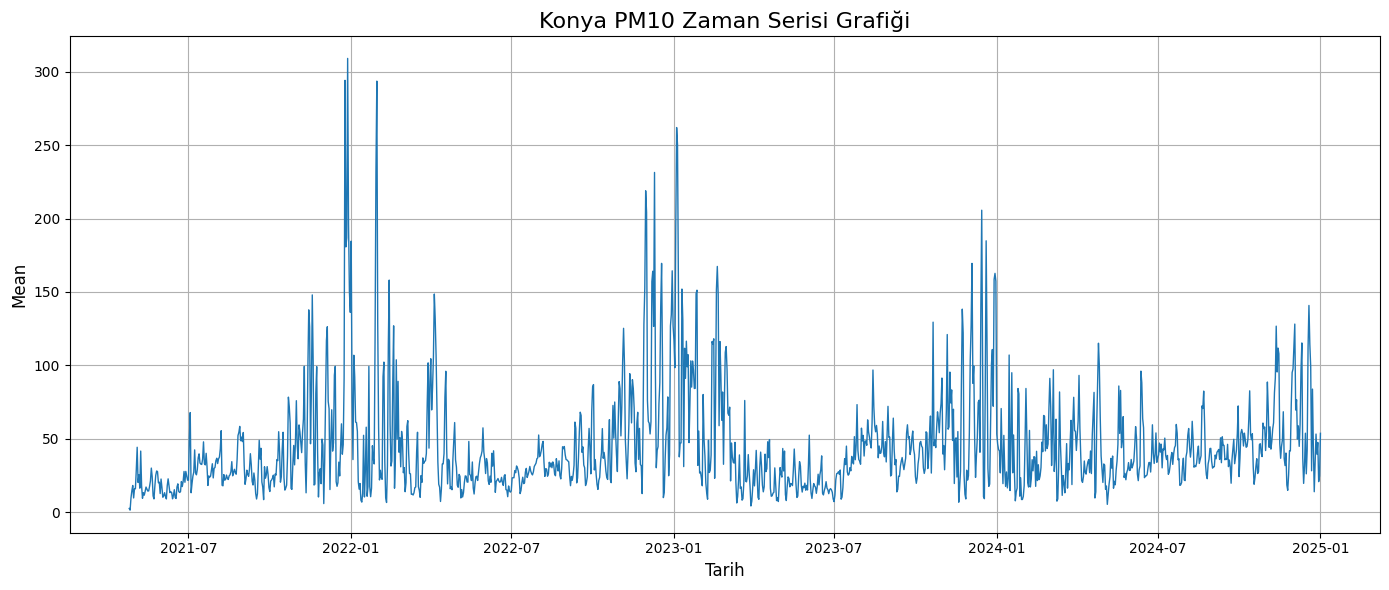

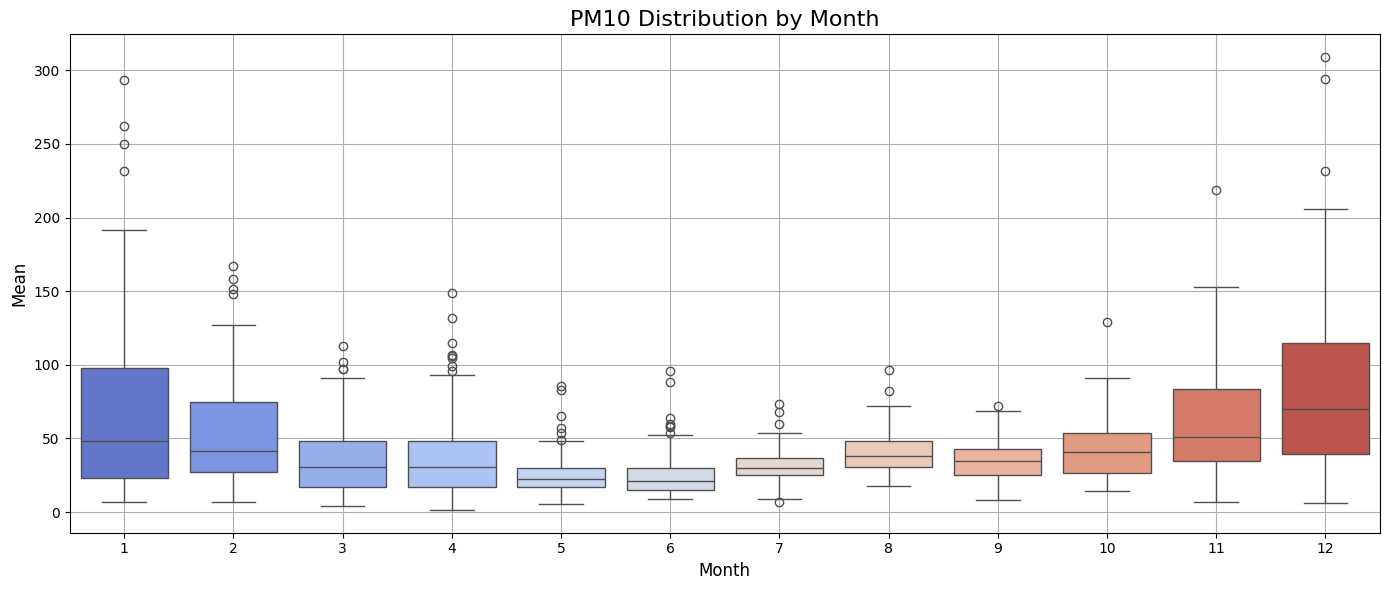

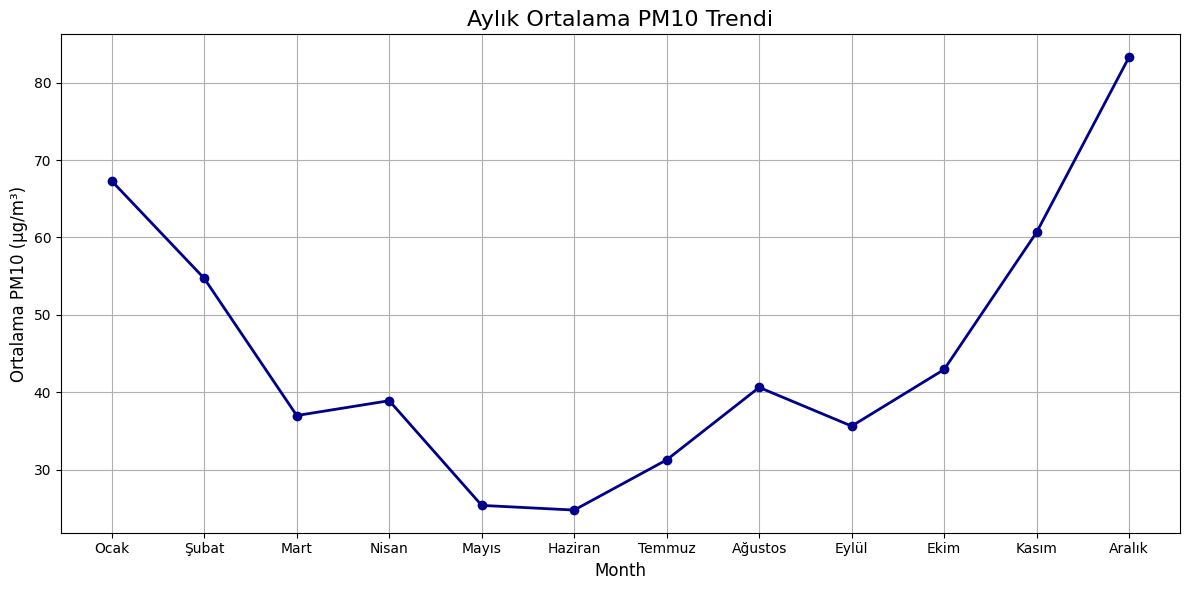

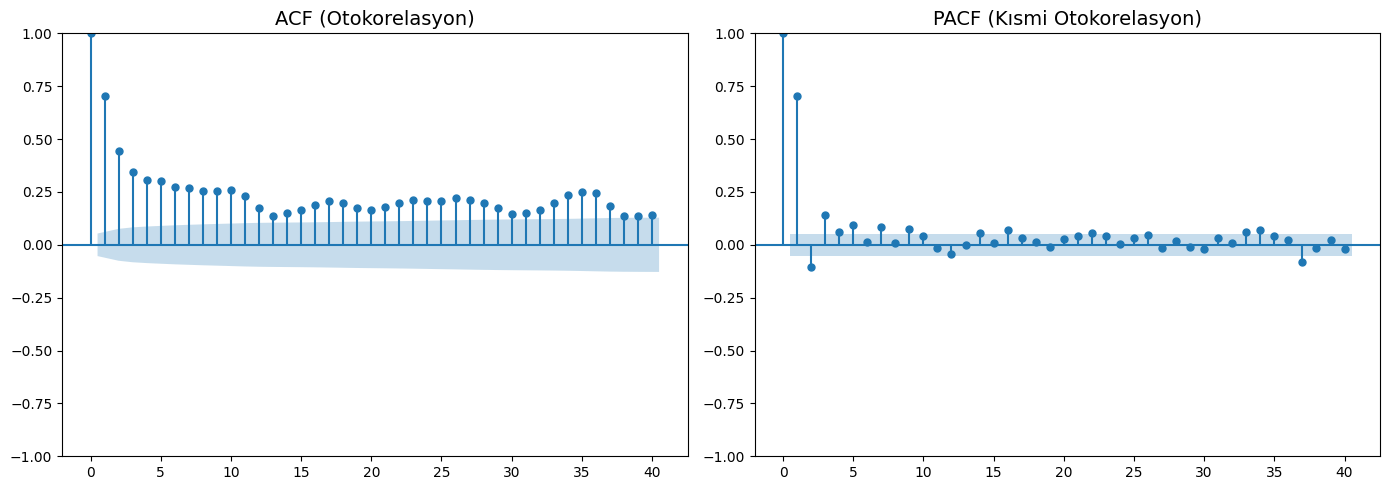

=== ADF (Augmented Dickey-Fuller) Testi: Log(PM10 Günlük Ortalama) ===
Test İstatistiği: -6.3551
p-değeri: 0.0000
Kritik Değerler:
   1%: -3.4352
   5%: -2.8637
   10%: -2.5679
→ ADF Sonucu: Seri durağandır (H0 reddedildi).

=== KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Testi: ===
Test İstatistiği: 0.6424
p-değeri: 0.0188
Kritik Değerler:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
→ KPSS Sonucu: Seri durağan değildir (H0 reddedildi).
                                      SARIMAX Results                                       
Dep. Variable:                             Mean_log   No. Observations:                 1348
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -887.542
Date:                              Sun, 01 Jun 2025   AIC                           1785.084
Time:                                      16:13:55   BIC                           1811.011
Sample:                                  04-25-2021   HQIC                        

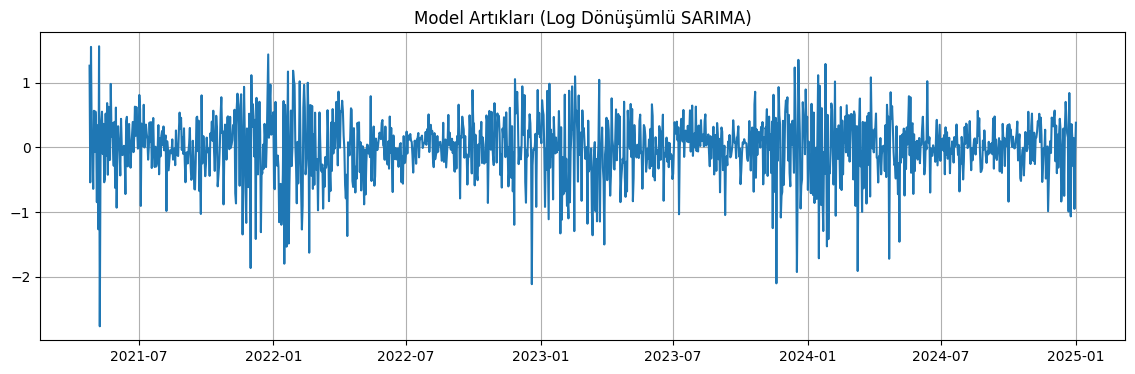

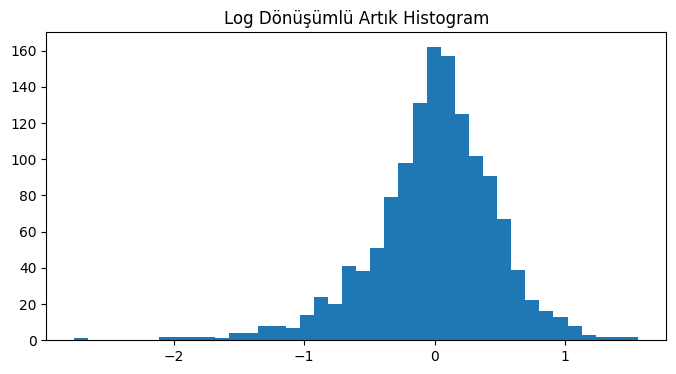

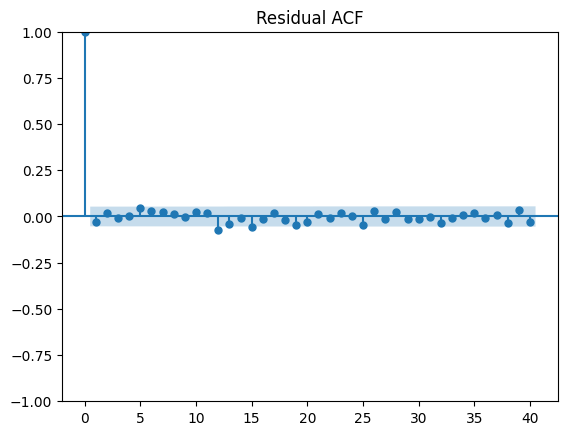

Breusch-Pagan Testi p-değeri: 0.0109 (p < 0.05 → heteroskedastisite var)
SARIMA -> RMSE: 22.63, MAE: 15.78
OLS -> RMSE: 37.32, MAE: 22.74
Huber -> RMSE: 39.01, MAE: 22.17


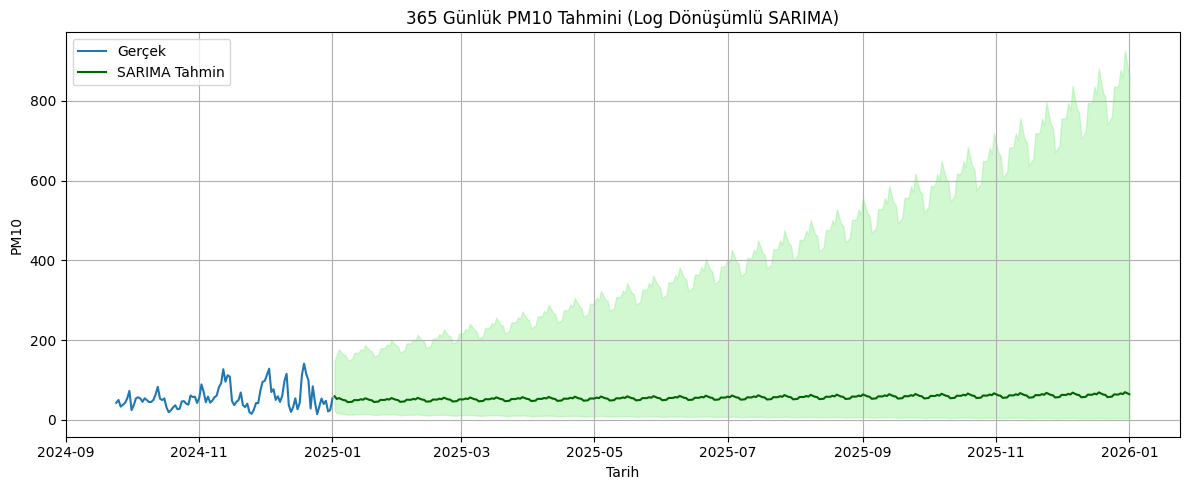

In [5]:
file_path = r"C:\Users\msı\Desktop\Konya Hava Kirliliği analizi\Pm10-KONYA.xlsx"
df = load_data(file_path)  
df["Mean_log"] = np.log1p(df["Mean"])

print(df.isnull().sum())            
detect_outliers_iqr(df, "Mean")      
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Mean"])
plt.title("Orijinal PM10 Boxplot")
plt.show()


plot_time_series(df, "Mean", title="Konya PM10 Zaman Serisi Grafiği")
df["Month"] = df.index.month
plot_monthly_boxplot(df, "Mean", "Month", "PM10 Distribution by Month")
aylik_ortalama = df.groupby("Month")["Mean"].mean().reset_index()
aylik_ortalama = aylik_ortalama.sort_values("Month")
plot_monthly_mean_trend(aylik_ortalama)
plot_acf_pacf(df, "Mean", lags=40)


run_stationarity_tests(df["Mean_log"], name="Log(PM10 Günlük Ortalama)")
model_sarima = SARIMAX(
    df["Mean_log"],
    order=(1, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_sarima = model_sarima.fit()
print(results_sarima.summary())
residuals = results_sarima.resid

plt.figure(figsize=(14, 4))
plt.plot(residuals)
plt.title("Model Artıkları (Log Dönüşümlü SARIMA)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=40)
plt.title("Log Dönüşümlü Artık Histogram")
plt.show()

plot_acf(residuals, lags=40)
plt.title("Residual ACF")
plt.show()


from statsmodels.tools.tools import add_constant
exog_bp = add_constant(np.arange(len(residuals.dropna())))
bp_test = het_breuschpagan(residuals.dropna(), exog_bp)
print(f"Breusch-Pagan Testi p-değeri: {bp_test[1]:.4f} (p < 0.05 → heteroskedastisite var)")


split_idx = int(0.8 * len(df))
train = df["Mean_log"].iloc[:split_idx]
test = df["Mean_log"].iloc[split_idx:]

model_train = SARIMAX(train,
                      order=(1, 1, 2),
                      seasonal_order=(0, 1, 1, 12),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_train = model_train.fit(disp=False)

forecast_log = results_train.get_forecast(steps=len(test))
preds_log = forecast_log.predicted_mean

preds_sarima = np.expm1(preds_log)
test_sarima = np.expm1(test)

rmse_sarima = np.sqrt(mean_squared_error(test_sarima, preds_sarima))
mae_sarima  = mean_absolute_error(test_sarima, preds_sarima)
print(f"SARIMA -> RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}")


df["Day_Num"] = np.arange(len(df))          
df["Month_str"] = df.index.month.astype(str)  

encoder = OneHotEncoder(drop="first", sparse_output=False)
month_dummies = encoder.fit_transform(df[["Month_str"]])

X = np.column_stack([df["Day_Num"].values.reshape(-1, 1), month_dummies])
y = df["Mean"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ols = LinearRegression().fit(X_train, y_train)
huber = HuberRegressor().fit(X_train, y_train)

evaluate_model("OLS", ols, X_test, y_test)
evaluate_model("Huber", huber, X_test, y_test)


forecast_full_log = results_sarima.get_forecast(steps=365)
forecast_full_mean = forecast_full_log.predicted_mean
conf_int = forecast_full_log.conf_int()


last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)

plt.figure(figsize=(12, 5))
plt.plot(df.index[-100:], df["Mean"].iloc[-100:], label="Gerçek")
plt.plot(forecast_index, np.expm1(forecast_full_mean), label="SARIMA Tahmin", color="darkgreen")
plt.fill_between(forecast_index,
                 np.expm1(conf_int.iloc[:, 0]),
                 np.expm1(conf_int.iloc[:, 1]),
                 color="lightgreen", alpha=0.4)
plt.title("365 Günlük PM10 Tahmini (Log Dönüşümlü SARIMA)")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
